In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import data
import train
from matplotlib import pyplot as plt
import torch
import numpy as np
import json
import random

In [3]:
input_dim=16
k=4
batch_size = 1024

In [25]:
disjoint_mixed_pool = data.create_mixed_clause_pool_random_disjoint(
    global_input_dim=input_dim,
    pool_size=256,
    features_per_and=4,
    seed=0,
)

In [ ]:
L = 1
R = 10
iterations = 10 # increase
T = 10000

stats = []

for num_clauses in range(L, R):
    for it in range(iterations):
        print(f"num_clauses: {num_clauses}, it: {it}")
        # Randomly select num_clauses clauses from the pool
        formula = random.sample(disjoint_mixed_pool, num_clauses)
        dset = data.create_dataset(
            cset=formula,
            input_dim=input_dim,
            train_size=10000,
            test_size=1000,
            min_true_vars=0,
            max_true_vars=4*num_clauses,
        )
        train_data, test_data = dset
        max_agg_steps = list(range(100, T+100, 100))
        plot_steps = []
        test_loader = data.create_dataloader(test_data, batch_size=batch_size)
        train_loader = data.create_dataloader(train_data, batch_size=batch_size)

        exp, model = train.run_single_model(
            run_name=f"k{num_clauses}_it{it}",
            max_aggregator_steps=max_agg_steps,
            plot_steps=plot_steps,
            input_dim=input_dim,
            hidden_dim=input_dim,
            num_features_per_clause=k,
            train_loader=train_loader,
            test_loader=test_loader,
            base_dir=".",
            l2_reg_factor=0,
            l1_reg_factor=1e-4,
            seed_offset=0,
            cset=formula,
            visualize=False,
            loss_diff_th=1e-5,
        )
        train_losses = exp.get_error_history(error_type="train")
        test_losses = exp.get_error_history(error_type="test")
        # print(model.fc1.weight.detach().cpu().numpy())
        cnt_nonzero = (model.fc1.weight.detach().cpu().numpy() > 1e-5).sum()
        print(cnt_nonzero)
        # total params in fc1.weight
        total_params = model.fc1.weight.detach().cpu().numpy().size
        print(total_params)

        l1 = 0.0
        for param in model.parameters():
            l1 += torch.sum(torch.abs(param))
        l1 = l1.item()

        print(train_losses[-10:])
        print(test_losses[-10:])
        stat = {
            "num_clauses": int(num_clauses),
            "train_loss": float(train_losses[-1]),
            "test_loss": float(test_losses[-1]),
            "nonzero_params": int(cnt_nonzero),
            "total_params": int(total_params),
            "train_loss_stability": float(train_losses[-1] - train_losses[-2]),
            "test_loss_stability": float(test_losses[-1] - test_losses[-2]),
            "l1": float(l1)
        }
        stats.append(stat)
        with open("./max_sparsity_stats_4_24.json", "w") as f:
            json.dump(stats, f)


num_clauses: 1, it: 0
k1_it0: using new random 4-AND formula => [[(5, False), (6, False), (10, False), (15, False)]]
num_batches: 9
136
256
[0.2658335  0.26705656 0.26517882 0.26386521 0.26292645 0.26407946
 0.26564964 0.26377219 0.26042178 0.26055361]
[1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09 1.e-09]
num_clauses: 1, it: 1
k1_it1: using new random 4-AND formula => [[(1, False), (7, False), (9, False), (15, False)]]
num_batches: 9


In [23]:
stats

[{'num_clauses': 1,
  'train_loss': 0.004080710148340778,
  'test_loss': 1e-09,
  'nonzero_params': 97,
  'total_params': 256,
  'train_loss_stability': -0.0001893680983860238,
  'test_loss_stability': 0.0,
  'l1': 78.48489379882812},
 {'num_clauses': 1,
  'train_loss': 0.0018191539474125755,
  'test_loss': 1e-09,
  'nonzero_params': 111,
  'total_params': 256,
  'train_loss_stability': -0.00027906215185985765,
  'test_loss_stability': 0.0,
  'l1': 82.43354797363281},
 {'num_clauses': 1,
  'train_loss': 0.0037116364232803647,
  'test_loss': 1e-09,
  'nonzero_params': 112,
  'total_params': 256,
  'train_loss_stability': -0.0004992694839050897,
  'test_loss_stability': 0.0,
  'l1': 79.3462142944336},
 {'num_clauses': 1,
  'train_loss': 0.0029130896773973576,
  'test_loss': 1e-09,
  'nonzero_params': 118,
  'total_params': 256,
  'train_loss_stability': -0.00034110849772236865,
  'test_loss_stability': 0.0,
  'l1': 80.46356964111328},
 {'num_clauses': 1,
  'train_loss': 0.002026800237792

Read saved json

In [17]:
stats = json.load(open("./max_sparsity_stats.json"))
L = min(stats, key=lambda x: x["num_clauses"])["num_clauses"]
R = max(stats, key=lambda x: x["num_clauses"])["num_clauses"]

In [18]:
stats_avg = []
for num_clauses in range(L, R+1):
    s = {}
    for key in stats[0].keys():
        s[key] = [s[key] for s in stats if s["num_clauses"] == num_clauses]
        s[key] = np.mean(s[key])
    stats_avg.append(s)
stats_avg

[{'num_clauses': 1.0,
  'train_loss': 0.2647885948419571,
  'test_loss': 1.0000000000000003e-09,
  'nonzero_params': 119.9,
  'total_params': 256.0,
  'train_loss_stability': -0.0018409608138931944,
  'test_loss_stability': 0.0,
  'l1': 45.582603454589844},
 {'num_clauses': 2.0,
  'train_loss': 0.25693291260136497,
  'test_loss': 1.0000000000000003e-09,
  'nonzero_params': 158.0,
  'total_params': 256.0,
  'train_loss_stability': -0.0005974554353290196,
  'test_loss_stability': 0.0,
  'l1': 89.73633575439453},
 {'num_clauses': 3.0,
  'train_loss': 0.34984561800956726,
  'test_loss': 1.0000000000000003e-09,
  'nonzero_params': 166.0,
  'total_params': 256.0,
  'train_loss_stability': -0.0014042986763848075,
  'test_loss_stability': 0.0,
  'l1': 86.69723510742188},
 {'num_clauses': 4.0,
  'train_loss': 0.2820799317624834,
  'test_loss': 1.0000000000000003e-09,
  'nonzero_params': 173.0,
  'total_params': 256.0,
  'train_loss_stability': 0.00421056482526988,
  'test_loss_stability': 0.0,


In [19]:
x = list(range(L, R+1))
nonzero_params = [s["nonzero_params"] for s in stats_avg]
train_loss = [s["train_loss"] for s in stats_avg]
test_loss = [s["test_loss"] for s in stats_avg]
train_loss_stability = [s["train_loss_stability"] for s in stats_avg]
test_loss_stability = [s["test_loss_stability"] for s in stats_avg]
l1 = [s["l1"] for s in stats_avg]

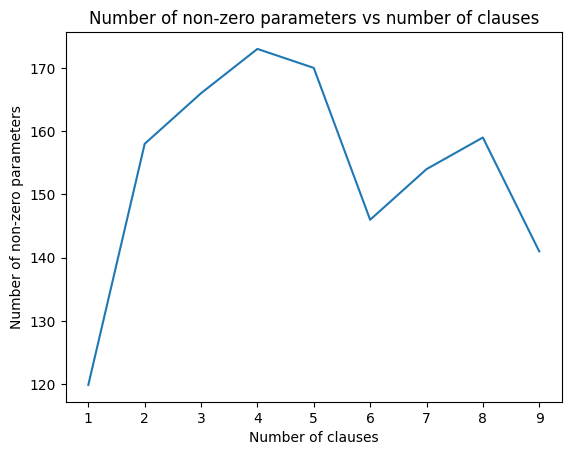

In [20]:
plt.plot(x, nonzero_params)
plt.xlabel("Number of clauses")
plt.ylabel("Number of non-zero parameters")
plt.title("Number of non-zero parameters vs. number of clauses")
plt.show()

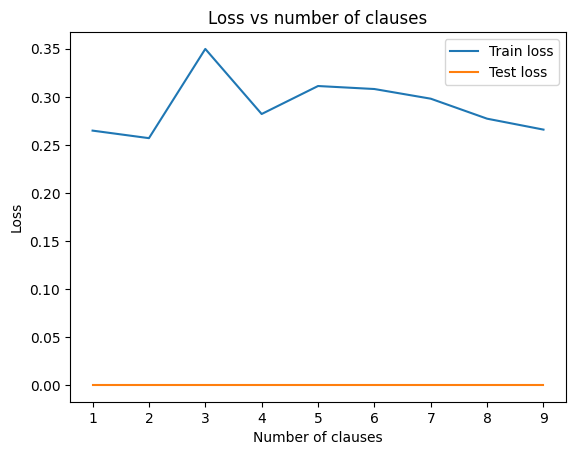

In [21]:
plt.plot(x, train_loss)
plt.plot(x, test_loss)
plt.xlabel("Number of clauses")
plt.ylabel("Loss")
plt.title("Loss vs number of clauses")
plt.legend(["Train loss", "Test loss"])
plt.show()

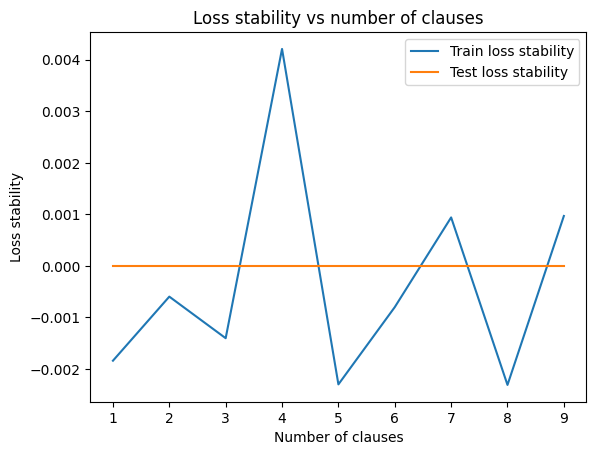

In [22]:
plt.plot(x, train_loss_stability)
plt.plot(x, test_loss_stability)
plt.xlabel("Number of clauses")
plt.ylabel("Loss stability")
plt.title("Loss stability vs number of clauses")
plt.legend(["Train loss stability", "Test loss stability"])
plt.show()

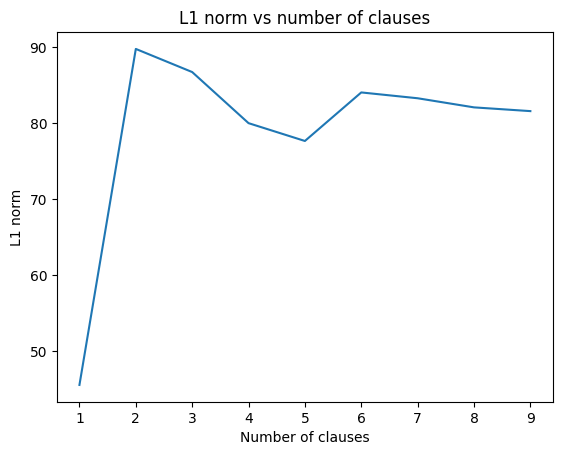

In [23]:
plt.plot(x, l1)
plt.xlabel("Number of clauses")
plt.ylabel("L1 norm")
plt.title("L1 norm vs number of clauses")
plt.show()